In [1]:
from model import UNET
from util import *
import tensorflow as tf
import numpy as np


import os
import tarfile

In [2]:
dataPath = os.path.join(".","Data","Images")
maskPath = os.path.join(".","Data","Segmentation")
dataType = "*.png"

SEED = 42
DATA_SPLIT = 1

OPTIMIZER = "adam"
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]
BATCH_SIZE = 16
IMAGE_SHAPE = (512,512,1)
KFOLD  = 3 #MUST BE >=2
EPOCHS = 2

In [3]:
if not os.path.isdir(dataPath) or not os.path.isdir(maskPath):
    #untar the data if it hasnt been
    print("UNZIPPING DATA")
    with tarfile.open(os.path.join(".","Data","data.tar.gz")) as file:
        file.extractall(os.path.join(".","Data"))


2022-03-08 19:36:53.571316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 19:36:53.571467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-08 19:36:53.742981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-08 19:36:53.743242: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro
# Folds = 3


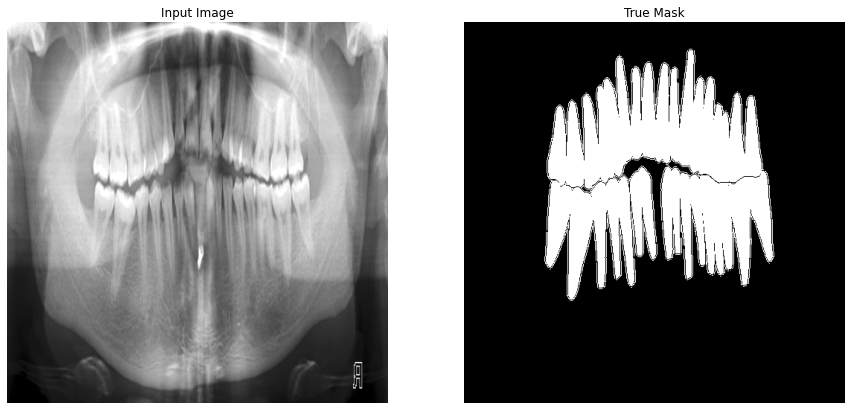

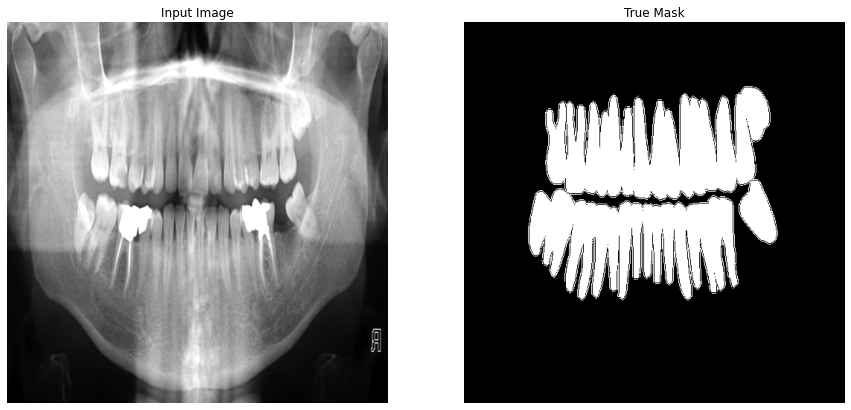

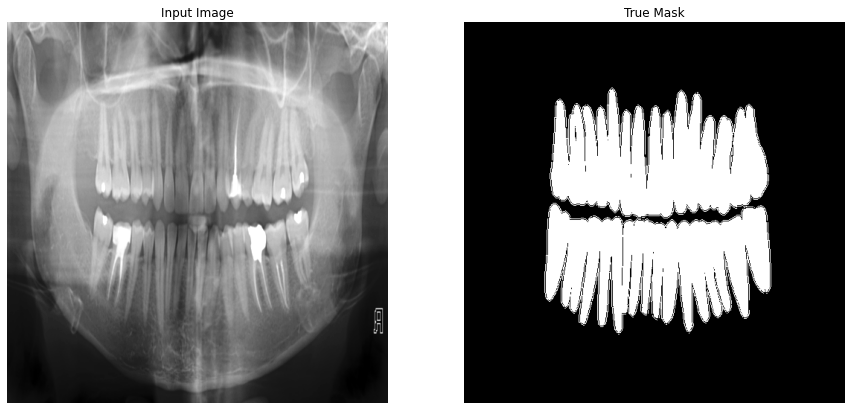

In [4]:
# LOAD DATASET AS TF DATASET
dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = IMAGE_SHAPE, batch_size = BATCH_SIZE,
                          kfold = KFOLD)
print("# Folds = {}".format(len(dataset)))
for element in dataset[0].take(1): #take a batch
    for b in range(min(3,BATCH_SIZE)): #now have a tuple
        display_mask_image([element[0][b],element[1][b]])

#for some reason, passing the dataset directly into the model is giving me all sorts of trouble, let us instead
#xtrain = np.array([x[0] for x in dataset])
#ytrain = np.array([x[1] for x in dataset])

In [5]:
print("IMAGE SHAPE -> {shp}".format(shp=IMAGE_SHAPE))
model = UNET(input_shape = IMAGE_SHAPE)
model.summary()
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

IMAGE SHAPE -> (512, 512, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
Down1A (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
Down1B (Dropout)                (None, 512, 512, 32) 0           Down1A[0][0]                     
__________________________________________________________________________________________________
Down1C (Conv2D)                 (None, 512, 512, 32) 9248        Down1B[0][0]                     
_________________________________________________________________

In [6]:
#history = model.fit(xtrain,ytrain,validation_split = 0.1, batch_size=16,epochs=10,verbose=1)
histories = []
for k in range(KFOLD):
    print("Doing k-fold {} of {}".format(k+1,KFOLD))
    test_dataset = dataset[k]
    train_datasets = []
    for k2 in range(KFOLD):
        if k2 == k:
            continue
        train_datasets.append(dataset[k2])
    train_dataset = train_datasets[0]
    for ds in train_datasets[1:]:
        train_dataset = train_dataset.concatenate(ds)
    
    model = UNET(input_shape = IMAGE_SHAPE)
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    history = model.fit(train_dataset, validation_data = test_dataset, \
                            epochs = EPOCHS, verbose = 1)
    histories.append(history.history)



Doing k-fold 1 of 3
Epoch 1/2


2022-03-08 19:36:55.230818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.4810

2022-03-08 19:37:14.629756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 23s 4s/step - loss: 0.7949 - accuracy: 0.4810 - val_loss: 21.1414 - val_accuracy: 0.7480
Epoch 2/2
6/6 [==============================] - 23s 4s/step - loss: 0.5308 - accuracy: 0.7619 - val_loss: 32.5170 - val_accuracy: 0.7577
Doing k-fold 2 of 3
Epoch 1/2


2022-03-08 19:37:41.741307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.7196

2022-03-08 19:38:01.029827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 23s 4s/step - loss: 0.5769 - accuracy: 0.7196 - val_loss: 61.9500 - val_accuracy: 0.7577
Epoch 2/2
6/6 [==============================] - 23s 4s/step - loss: 0.4453 - accuracy: 0.7659 - val_loss: 79.5901 - val_accuracy: 0.7466
Doing k-fold 3 of 3
Epoch 1/2


2022-03-08 19:38:28.287623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7297

2022-03-08 19:38:48.067428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 24s 4s/step - loss: 0.5664 - accuracy: 0.7297 - val_loss: 28.0526 - val_accuracy: 0.7597
Epoch 2/2
6/6 [==============================] - 23s 4s/step - loss: 0.4704 - accuracy: 0.7749 - val_loss: 12.8378 - val_accuracy: 0.5687


In [7]:
history  = {}
history["loss"] = np.mean([hstry["loss"] for hstry in histories],axis=0)
history["accuracy"] = np.mean([hstry["accuracy"] for hstry in histories],axis=0)
history["val_loss"] = np.mean([hstry["val_loss"] for hstry in histories],axis=0)
history["loss"] = np.mean([hstry["val_accuracy"] for hstry in histories],axis=0)

[{'loss': [0.7948855757713318, 0.5307837128639221],
  'accuracy': [0.48099106550216675, 0.7619426250457764],
  'val_loss': [21.141401290893555, 32.51704406738281],
  'val_accuracy': [0.7479611039161682, 0.7576682567596436]},
 {'loss': [0.5769098401069641, 0.4452875256538391],
  'accuracy': [0.719629168510437, 0.7658523321151733],
  'val_loss': [61.949981689453125, 79.59007263183594],
  'val_accuracy': [0.7577105164527893, 0.746612548828125]},
 {'loss': [0.5664475560188293, 0.4703831970691681],
  'accuracy': [0.7297194600105286, 0.7748677730560303],
  'val_loss': [28.052597045898438, 12.837810516357422],
  'val_accuracy': [0.7596504092216492, 0.5687080025672913]}]

In [22]:
combine

['loss', 'accuracy']

In [17]:
print(np.mean([histories[0].history["loss"],histories[1].history["loss"]],axis=0))
print(np.mean([histories[0].history["loss"][0],histories[1].history["loss"][0]]))

[0.70221141 0.54299369 0.52229783]
0.7022114098072052


# Lets view results after training

2022-03-08 18:11:12.658766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


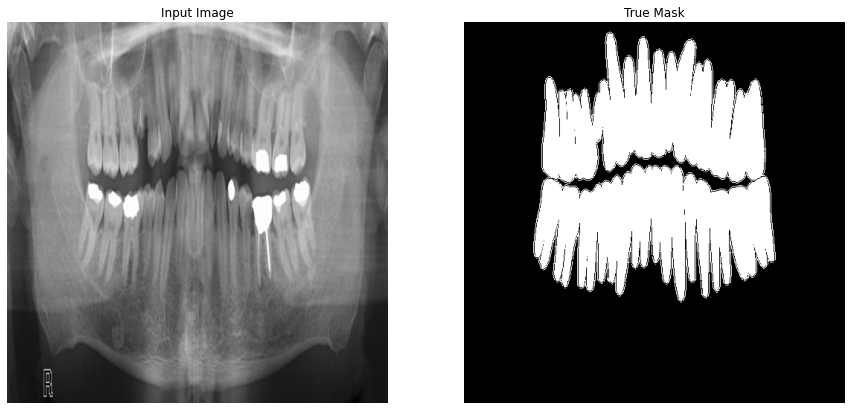

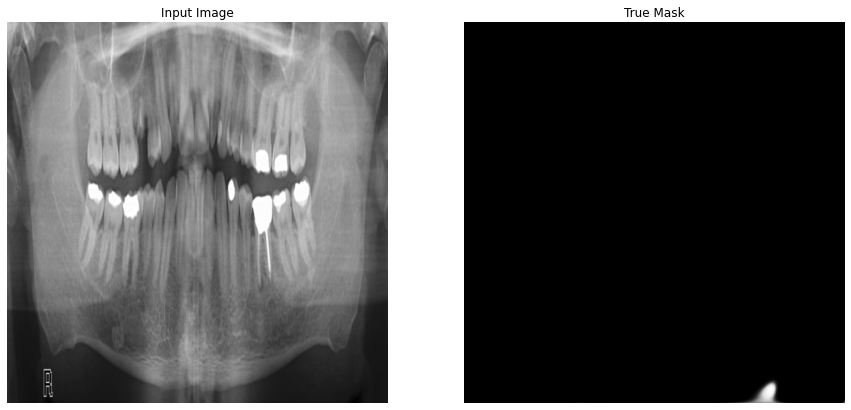

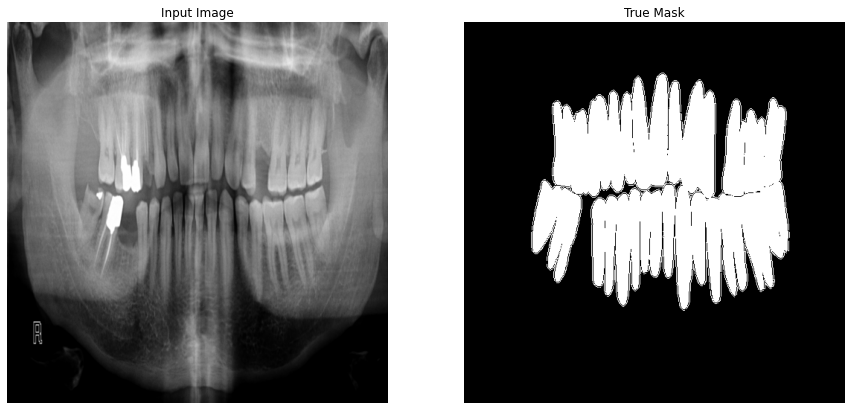

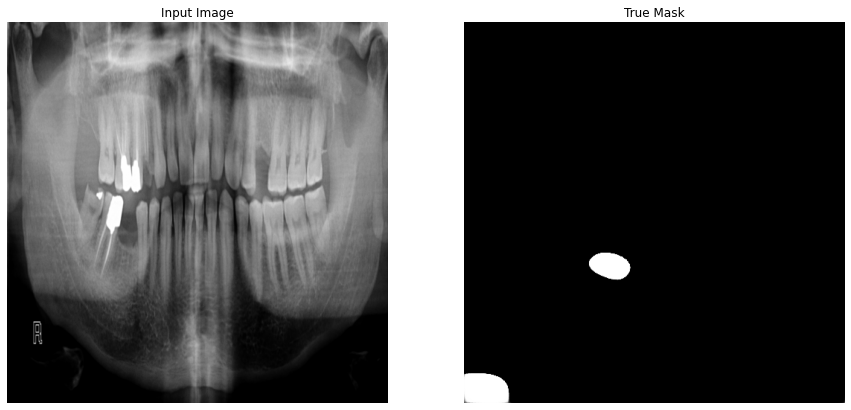

In [7]:
#TRAINING
for element in dataset.take(1): #take a batch
    predictions = model.predict(element[0])
    for b in range(min(2,BATCH_SIZE)): #now have a tuple
        display_mask_image([element[0][b],element[1][b]])
        display_mask_image([element[0][b],predictions[b]])

In [8]:
history.history

{'loss': [0.5857512950897217, 0.37967655062675476, 0.26122790575027466],
 'accuracy': [0.6620679497718811, 0.8116366863250732, 0.890103816986084]}

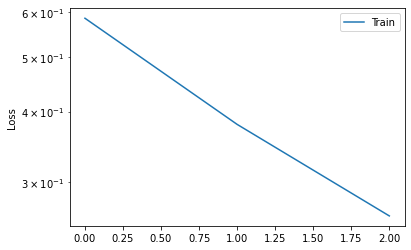

In [9]:
plt.semilogy(history.history["loss"],label="Train")
plt.ylabel("Loss")
plt.legend()

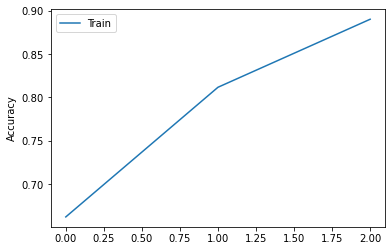

In [10]:
plt.plot(history.history["accuracy"],label="Train")
plt.ylabel("Accuracy")
plt.legend()